# Ask Wiki Problem definition 
AskWiki must perform 2 tasks sequentially, first is to construct a SPARQL query based on question, second task is to verbalize and generate an answer from the query results. 

Author: shrinivasbjoshi@berkeley.edu

#NL generation based on wikidata triples 
To generate NL answer to a question, Askwiki must input wikidata triples into NLG model and generate and summarize an english language response. 

We considered T5 and OpenAi model families as candidates for the NLG. 


Intution behind choosing T5 & OpenAI models 
1. T5 will offer larger training and fine tuning opportunities 
2. OpenAI offers wider selection of models and easier few shot training approaches 


This Notebook provides overview of our T5 small NLG training and generation. 

Approach to NL generation using WEB NLG 2020 challenge data 

1. Training on webnlg 2020 data set

 WebNLG dataset provided ready to use RDF triples [similar to how Askwiki will generate triples] and annotated human language responses for those triples  
 
2. Askwiki intends to answer a specific question using NL and does not want to just summarize set of triples into a paragraph. For those purposes we have not done extensive tuning of T5 models in this notebook, onus of generating an answer is on the eariler pipeline of the code and not necessrily on the NLG model. 

3. This model is just reacting to the input RDF tiples , AskWiki did not have access to any specific question answer database for finetuning and utilized the webnlg dataset as language generator and summarizer trainer [not as answering model]




## Installing the required packages

In [ ]:
!pip install transformers
!pip install sentencepiece
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.5 MB/s eta 0:00:00


If you just want to test the pre trained model jump to W210 testing section and import the model from hugging face

## Preprocess the data

 webnlg2020 data from gitlab directly

In [ ]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('AskWiki NLG: ')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [ ]:
df[df['target_text']=='The Aarhus is the airport of Aarhus, Denmark.']

,prefix,input_text,target_text
7784,AskWiki NLG:,"Aarhus_Airport | cityServed | ""Aarhus, Denmark""","The Aarhus is the airport of Aarhus, Denmark."


In [ ]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

In [ ]:
#Perform Train and Test Split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_df, test_size=0.3)

In [ ]:
train_df.count()

prefix         24639
input_text     24639
target_text    24639
dtype: int64

In [ ]:
test_df.count()

prefix         10560
input_text     10560
target_text    10560
dtype: int64

In [ ]:
batch_size=6
num_of_batches=int(len(train_df)/batch_size)
num_of_epochs=4

In [ ]:
num_of_batches

4107

Checking for the GPU availability

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = T5ForConditionalGeneration.from_pretrained('t5-large', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

## Initializing the optimizer 
(tips from hugging face, utilizing the same adapter on which t5 was trained)
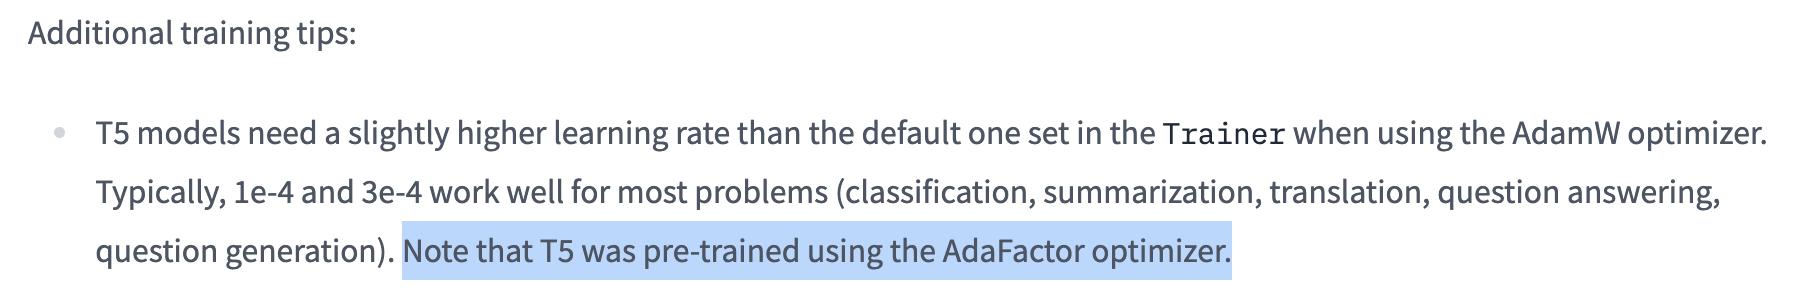

In [ ]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

## Training the model

In [ ]:
train_df.count()

prefix         24647
input_text     24647
target_text    24647
dtype: int64

In [ ]:
#modified training code 
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'AskWiki NLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    input=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=768,return_tensors='pt')
    label=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=768,return_tensors="pt")
    inputbatch=input["input_ids"]
    inputattention=input["attention_mask"]
    labelbatch=label["input_ids"]
    labelattention=label["attention_mask"]

    #send to GPU
    inputbatch=inputbatch.to(dev)
    inputattention=inputattention.to(dev)
    labelbatch=labelbatch.to(dev)
    labelattention=labelattention.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch
                    ,attention_mask=inputattention
                    ,labels=labelbatch
                    ,decoder_attention_mask=labelattention
                    )
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 0.5496556688492856
Running epoch: 2


Epoch: 2 , Running loss: 0.40919128663534954
Running epoch: 3


Epoch: 3 , Running loss: 0.3523144597373132
Running epoch: 4


Epoch: 4 , Running loss: 0.3130683382392104


## Plotting the loss over time

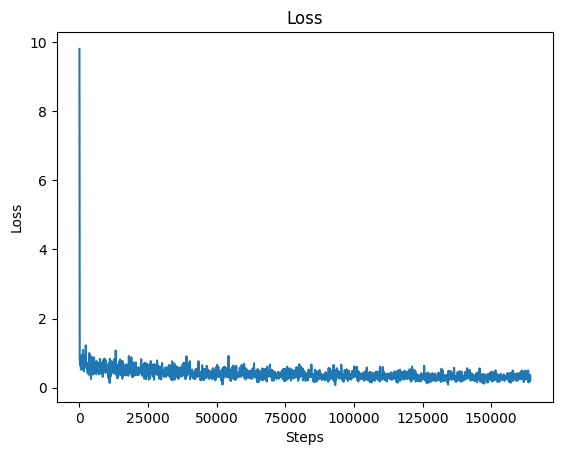

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

#Push to huggingface

In [ ]:
model.push_to_hub("V4T5LARGE")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shrinivasbjoshi/V4T5LARGE/commit/5d1cc2305e717081e73b4733e3a0e0e0fcdca6be', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='5d1cc2305e717081e73b4733e3a0e0e0fcdca6be', pr_url=None, pr_revision=None, pr_num=None)

##AskWiki Testing

In [ ]:
#if you have come here without training model then start from here
from transformers import AutoModel
tokenizer = T5Tokenizer.from_pretrained('t5-large')

In [ ]:
AskWiki_NLG = T5ForConditionalGeneration.from_pretrained('shrinivasbjoshi/V4T5LARGE', return_dict=True)

In [ ]:
AskWiki_NLG.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [ ]:
input_ids = tokenizer.encode("AskWiki NLG: shrinivas | description | student && shrinivas | surname | joshi && shrinivas | student | UC Berkeley  && shrinivas | hair color | salt&pepper && shrinivas | age | 42  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = AskWiki_NLG.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>shrinivas is a student at UC Berkeley and has the full name of'

In [ ]:
t_input_ids = tokenizer.encode("AskWiki NLG: shrinivas | description | student && shrinivas | surname | joshi && shrinivas | student | UC Berkeley  && shrinivas | hair color | salt&pepper && shrinivas | age | 42  </s>", return_tensors="pt")  # Batch size 1
t_input_ids=t_input_ids.to(dev)
#outputs = AskWiki_NLG.generate(input_ids)


In [ ]:
input=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=768,return_tensors='pt')

tensor([[ 8366,   518,  9069,   445, 24214,    10,     3, 31763,    29,  6823,
             7,  1820,  4210,  1820,  1236,     3,   184,   184,     3, 31763,
            29,  6823,     7,  1820,   244,  4350,  1820,     3,  1927,  5605,
             3,   184,   184,     3, 31763,    29,  6823,     7,  1820,  1236,
          1820,     3,  6463, 20776,     3,   184,   184,     3, 31763,    29,
          6823,     7,  1820,  1268,   945,  1820,  3136,   184,   855,  8153,
             3,   184,   184,     3, 31763,    29,  6823,     7,  1820,  1246,
          1820,  6426,     1]], device='cuda:0')

In [ ]:
d_outputs_1 = model.generate(t_input_ids,do_sample=False,num_beams=6)

tokenizer.decode(d_outputs_1[0])

'<pad>Srinivas is a student at UC Berkeley and has the full name of'

T5 large does generate random outputs based on num of beams as evidenced above, the model would definitely need more rigorous training for AskWiki purposes, ideally on multiple GPUs and larger dataset and additional number of epochs


# Compute Metrics on Generation



In [ ]:
test_df.count()

prefix         10560
input_text     10560
target_text    10560
dtype: int64

In [ ]:
batch_size=6
num_of_batches=int(len(test_df)/batch_size)
num_of_epochs=4

In [ ]:
test_df

,prefix,input_text,target_text
1133,AskWiki NLG:,ALCO_RS-3 | builder | American_Locomotive_Comp...,The ALCO RS-3 has a V12 engine and is built by...
8795,AskWiki NLG:,A.F.C._Fylde | manager | Dave_Challinor && Dav...,"Affiliated with Tranmere Rovers F.C., Dave Cha..."
10657,AskWiki NLG:,Bakewell_pudding | region | Derbyshire_Dales &...,The dessert Bakewell pudding is from the Derby...
4287,AskWiki NLG:,Aleksandr_Prudnikov | club | FC_Terek_Grozny &...,Aleksandr Prudnikov played for FC Terek Grozny...
20545,AskWiki NLG:,"Richland_Township,_Madison_County,_Indiana | c...","Richland Township, in Madison County, Indiana ..."
...,...,...,...
29259,AskWiki NLG:,"Above_the_Veil | numberOfPages | ""248"" && Abov...",Above the Veil by Garth Nix was produced in Pr...
6312,AskWiki NLG:,109_Felicitas | mass | 7.5 (kilograms) && 109_...,109 Felicitas has a mass of 7.5 kg and an apoa...
34528,AskWiki NLG:,Alcatraz_Versus_the_Evil_Librarians | language...,Alcatraz Versus the Evil Librarians is an Engl...
22373,AskWiki NLG:,Adam_Holloway | battle | Gulf_War && Adam_Holl...,Adam Holloway was in the Grenadier Guards in t...


In [ ]:
#take a sample of  rows from test data to evaluate 
sample_test_df=test_df.sample(frac=0.01)

In [ ]:
sample_test_df.count()

prefix         106
input_text     106
target_text    106
dtype: int64

In [ ]:
import inspect
inspect.signature(AskWiki_NLG.generate)

<Signature (inputs: Optional[torch.Tensor] = None, generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None, logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None, stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None, prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None, synced_gpus: Optional[bool] = None, streamer: Optional[ForwardRef('BaseStreamer')] = None, **kwargs) -> Union[transformers.generation.utils.GreedySearchEncoderDecoderOutput, transformers.generation.utils.GreedySearchDecoderOnlyOutput, transformers.generation.utils.SampleEncoderDecoderOutput, transformers.generation.utils.SampleDecoderOnlyOutput, transformers.generation.utils.BeamSearchEncoderDecoderOutput, transformers.generation.utils.BeamSearchDecoderOnlyOutput, transformers.generation.utils.BeamSampleEncoderDecoderOutput, transformers.generation.utils.BeamSample

In [ ]:
#test cycle
AskWiki_outputs_top=[]
AskWiki_outputs_beams =[]
for indx,row in sample_test_df.iterrows():
  input = 'AskWiki NLG: '+row['input_text']+'</s>'   
  input=tokenizer(input,padding=True,max_length=768,return_tensors='pt')
  input=input.to(dev)
  #Generate inferences
  #output_sequences = AskWiki_NLG.generate(input_ids=input["input_ids"],attention_mask=input["attention_mask"],do_sample=False,)
  #AskWiki_outputs.append(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))
  outputs_top = AskWiki_NLG.generate(input_ids=input["input_ids"],attention_mask=input["attention_mask"],do_sample=False,num_beams=4, no_repeat_ngram_size=2, min_length=50, max_length=100)
  AskWiki_outputs_top.append(tokenizer.batch_decode(outputs_top, skip_special_tokens=True))
  outputs_beams = AskWiki_NLG.generate(input_ids=input["input_ids"],attention_mask=input["attention_mask"],do_sample=True,top_k=50,top_p=0.95,num_return_sequences=1, min_length=50, max_length=100)
  AskWiki_outputs_beams.append(tokenizer.batch_decode(outputs_beams, skip_special_tokens=True))
AskWiki_outputs_beams= list(np.concatenate(AskWiki_outputs_beams))
AskWiki_outputs_top= list(np.concatenate(AskWiki_outputs_top))


In [ ]:
len(AskWiki_outputs_beams)

106

In [ ]:
len(AskWiki_outputs_top)

106

In [ ]:
AskWiki_outputs_top

['Alfred Moore Scales was a member of the Democratic Party in the U.S. He was Governor of North Carolina and was preceded by James Madison Leach. Mr. Watson was also the successor to Alfred Mollinle.',
 'Len Wein was awarded an award from the Academy of Comic Book Arts (.) of the same year. The book is also home to the award "Assocessor to another one. "In a \'Dean of comic book arts.',
 'AmeriGas is a company in the energy industry that serves the United States and has an operating income of $380,700,000 from operating revenue of 380700000. The U.S. is home to an impressive income.',
 'Associazione Calcio Chievo Verona is managed by Rolando Maran, who is a member of the Unione Triestina 2012 S.S.D. club. The manager of A.C. Chiavo veronara.',
 "The ground of A.E Dimitra Efxeinoupolis is located in the town of Etxinoupoli. The town is the location of the home to the A 'Alea di Mendrisio.",
 "Alison O'Donnell started performing in 1963 and was a member of the Mellow Candle and Bajik ban

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def bleu_calc(reference, candidate):
    return sentence_bleu(reference.split(), candidate.split())

In [ ]:
sample_test_df["candidate_text_beams"] = AskWiki_outputs_beams
sample_test_df["candidate_text_top"] = AskWiki_outputs_top

In [ ]:
sample_test_df

,prefix,input_text,target_text,candidate_text,blue_score,candidate_text_beams,candidate_text_top,blue_score_beam,blue_score_top
2550,AskWiki NLG:,"Alfred_Moore_Scales | office | ""Governor of No...","Alfred Moore Scales, a member of the Democrati...","Alfred Moore Scales, who was Governor of North...",0.0,Democratic Governor Alfred Moore Scales of Nor...,Alfred Moore Scales was a member of the Democr...,0.000000e+00,7.490164e-232
9126,AskWiki NLG:,Len_Wein | award | Academy_of_Comic_Book_Arts,Len Wein has won awards from the Academy of Co...,Len Wein was awarded an award from the Academy...,0.0,Len Wein was awarded the Academy of Comic Book...,Len Wein was awarded an award from the Academy...,0.000000e+00,7.386826e-232
6732,AskWiki NLG:,AmeriGas | regionServed | United_States && Ame...,AmeriGas an energy industry provides services ...,AmeriGas is a company in the energy industry t...,0.0,"AmeriGas, an energy industry produces that ear...",AmeriGas is a company in the energy industry t...,0.000000e+00,7.601159e-232
28333,AskWiki NLG:,A.C._Chievo_Verona | manager | Rolando_Maran &...,Associazione Calcio Chievo Verona is managed b...,Associazione Calcio Chievo Verona is managed b...,0.0,The manager of A.C. Chievo Verona is Rolando M...,Associazione Calcio Chievo Verona is managed b...,0.000000e+00,8.067983e-232
11780,AskWiki NLG:,A.E_Dimitra_Efxeinoupolis | ground | Efxeinoupoli,The ground of A.E Dimitra Efxeinoupolis is loc...,The ground of A.E Dimitra Efxeinoupolis is loc...,0.0,A.E Dimitra Efxeinoupolis ground is located in...,The ground of A.E Dimitra Efxeinoupolis is loc...,0.000000e+00,7.992219e-232
...,...,...,...,...,...,...,...,...,...
23524,AskWiki NLG:,Austria | leader | Doris_Bures && Alfons_Gorba...,"Austrian German is the language in Austria, th...","Alfons Gorbach was born in Imst, in the state ...",0.0,"Alfons Gorbach was born in Imst, Tyrol state a...","Alfons Gorbach was born in Imst, in the state ...",8.907356e-232,7.720900e-232
2049,AskWiki NLG:,Ab_Klink | almaMater | Erasmus_University_Rott...,"Ab Klink, worked as a Member of the House of R...",Ab Klink worked as a member of the House of Re...,0.0,Ab Klink worked at the House of Representative...,Ab Klink worked as a member of the House of Re...,7.244248e-232,7.544641e-232
17291,AskWiki NLG:,Alberto_Teisaire | deathPlace | Buenos_Aires &...,"Alberto Teisaire, a member of the Justicialist...",Alberto Teisaire was a member of the Justicial...,0.0,Alberto Teisaire was a member of the Justicial...,Alberto Teisaire was a member of the Justicial...,7.784451e-232,7.784451e-232
28719,AskWiki NLG:,Luciano_Spalletti | club | Udinese_Calcio && A...,Luciano Spalletti manages A S Roma and plays f...,"A.S. Roma's manager is Luciano Spalletti, who ...",0.0,"AS Roma's manager is Luciano Spalletti, who is...","A.S. Roma's manager is Luciano Spalletti, who ...",0.000000e+00,9.788429e-232


In [ ]:
# Apply the function to the DataFrame
sample_test_df['blue_score_beam'] = sample_test_df.apply(lambda row: bleu_calc(row['target_text'], row['candidate_text_beams']), axis=1)
sample_test_df['blue_score_top'] = sample_test_df.apply(lambda row: bleu_calc(row['target_text'], row['candidate_text_top']), axis=1)

In [ ]:
import textstat


In [ ]:
#reading score
sample_test_df['top_reading_score'] = sample_test_df.apply(lambda row: textstat.flesch_reading_ease(row['candidate_text_top']), axis=1)
sample_test_df['beam_reading_score'] = sample_test_df.apply(lambda row: textstat.flesch_reading_ease(row['candidate_text_beams']), axis=1)

In [ ]:
sample_test_df['top_words']=sample_test_df['candidate_text_top'].apply(lambda x: len(x.split()))
sample_test_df['beam_words']=sample_test_df['candidate_text_beams'].apply(lambda x: len(x.split()))

In [ ]:
np.mean(sample_test_df['top_words'])

35.632075471698116

In [ ]:
np.mean(sample_test_df['beam_words'])

33.91509433962264

In [ ]:
sample_test_df

,prefix,input_text,target_text,candidate_text,blue_score,candidate_text_beams,candidate_text_top,blue_score_beam,blue_score_top,top_reading_score,beam_reading_score
2550,AskWiki NLG:,"Alfred_Moore_Scales | office | ""Governor of No...","Alfred Moore Scales, a member of the Democrati...","Alfred Moore Scales, who was Governor of North...",0.0,Democratic Governor Alfred Moore Scales of Nor...,Alfred Moore Scales was a member of the Democr...,0.000000e+00,7.490164e-232,68.06,61.83
9126,AskWiki NLG:,Len_Wein | award | Academy_of_Comic_Book_Arts,Len Wein has won awards from the Academy of Co...,Len Wein was awarded an award from the Academy...,0.0,Len Wein was awarded the Academy of Comic Book...,Len Wein was awarded an award from the Academy...,0.000000e+00,7.386826e-232,87.72,88.43
6732,AskWiki NLG:,AmeriGas | regionServed | United_States && Ame...,AmeriGas an energy industry provides services ...,AmeriGas is a company in the energy industry t...,0.0,"AmeriGas, an energy industry produces that ear...",AmeriGas is a company in the energy industry t...,0.000000e+00,7.601159e-232,54.73,53.58
28333,AskWiki NLG:,A.C._Chievo_Verona | manager | Rolando_Maran &...,Associazione Calcio Chievo Verona is managed b...,Associazione Calcio Chievo Verona is managed b...,0.0,The manager of A.C. Chievo Verona is Rolando M...,Associazione Calcio Chievo Verona is managed b...,0.000000e+00,8.067983e-232,66.74,79.56
11780,AskWiki NLG:,A.E_Dimitra_Efxeinoupolis | ground | Efxeinoupoli,The ground of A.E Dimitra Efxeinoupolis is loc...,The ground of A.E Dimitra Efxeinoupolis is loc...,0.0,A.E Dimitra Efxeinoupolis ground is located in...,The ground of A.E Dimitra Efxeinoupolis is loc...,0.000000e+00,7.992219e-232,79.26,72.32
...,...,...,...,...,...,...,...,...,...,...,...
23524,AskWiki NLG:,Austria | leader | Doris_Bures && Alfons_Gorba...,"Austrian German is the language in Austria, th...","Alfons Gorbach was born in Imst, in the state ...",0.0,"Alfons Gorbach was born in Imst, Tyrol state a...","Alfons Gorbach was born in Imst, in the state ...",8.907356e-232,7.720900e-232,72.66,68.06
2049,AskWiki NLG:,Ab_Klink | almaMater | Erasmus_University_Rott...,"Ab Klink, worked as a Member of the House of R...",Ab Klink worked as a member of the House of Re...,0.0,Ab Klink worked at the House of Representative...,Ab Klink worked as a member of the House of Re...,7.244248e-232,7.544641e-232,45.76,49.52
17291,AskWiki NLG:,Alberto_Teisaire | deathPlace | Buenos_Aires &...,"Alberto Teisaire, a member of the Justicialist...",Alberto Teisaire was a member of the Justicial...,0.0,Alberto Teisaire was a member of the Justicial...,Alberto Teisaire was a member of the Justicial...,7.784451e-232,7.784451e-232,56.25,64.71
28719,AskWiki NLG:,Luciano_Spalletti | club | Udinese_Calcio && A...,Luciano Spalletti manages A S Roma and plays f...,"A.S. Roma's manager is Luciano Spalletti, who ...",0.0,"AS Roma's manager is Luciano Spalletti, who is...","A.S. Roma's manager is Luciano Spalletti, who ...",0.000000e+00,9.788429e-232,67.76,54.90


In [ ]:
np.mean(sample_test_df['top_reading_score'])

69.34481132075472

In [ ]:
np.mean(sample_test_df['beam_reading_score'])

68.77377358490565